In [61]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import pickle
import random
import importlib
import sys

import shap
from pdpbox import pdp
import matplotlib.pyplot as plt
import japanize_matplotlib

In [62]:
import common

# モジュールの再読み込み
importlib.reload(common)

_common = common.Common()
_common.BASE_PATH

PosixPath('/Users/iwasakitakahiro/github')

In [63]:
common_func_path = _common.COMMON_FUNC_PATH
sys.path.append(str(common_func_path))

import func

importlib.reload(func)

<module 'func' from '/Users/iwasakitakahiro/github/共通関数/func.py'>

In [64]:
train_df = pd.read_csv('../output/中間データ/学習用データ/train_preprocessed.csv')
train_df.head()

,price_actual,total_load_actual,time,gene_sum,gene_load_ratio,residual_demand,high_cost_ratio,tight_supply_flag,hour,weekday,...,total_load_actual_exp_std_to_t,total_load_actual_scaled,weighted_wind_speed,weighted_temp,weighted_pressure,weighted_dew_point,weighted_clouds_all,pc_a_1,pc_a_2,pc_a_3
0,54.70,22734.0,2015-01-02 01:00:00+00:00,25070.0,1.102754,14358.0,0.393738,0,0.261799,-2.019595,...,501.500000,-4.286142,1.493827,273.378658,1005.708505,270.403014,0.000000,-367.947886,-5770.843730,1438.583165
1,54.91,21286.0,2015-01-02 02:00:00+00:00,23232.0,1.091422,13757.0,0.378271,0,0.523599,-2.019595,...,1092.891882,-2.636125,1.493827,273.361152,1005.708505,270.385650,0.000000,-376.199021,-7480.541994,1483.372071
2,53.07,20264.0,2015-01-02 03:00:00+00:00,22375.0,1.104175,13112.0,0.376134,0,0.785398,-2.019595,...,1565.914968,-2.032518,1.493827,273.361995,1005.734568,270.390270,0.260631,-380.482005,-8569.749564,1443.351232
3,54.23,19905.0,2015-01-02 04:00:00+00:00,21713.0,1.090831,13074.0,0.379128,0,1.047198,-2.019595,...,1892.737531,-1.534920,1.102881,272.899560,1006.657064,269.739788,0.156379,-380.817754,-8999.368726,1300.109665
4,58.22,20010.0,2015-01-02 05:00:00+00:00,21379.0,1.068416,13295.0,0.385331,0,1.308997,-2.019595,...,2039.026156,-1.135836,1.102881,272.894287,1006.657064,269.738265,0.338820,-379.967582,-8929.906089,1091.049829


In [65]:
X_train = train_df.drop(columns=['price_actual', 'time'])
y_train = np.log1p(train_df['price_actual'])

In [66]:
# 再現性確保のための固定シード
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)

# Optunaのシードも固定
sampler = optuna.samplers.TPESampler(seed=SEED)

default_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'verbosity': 0,
    'seed': 1234
}

In [67]:
tscv = TimeSeriesSplit(n_splits=36)

#### ハイパーパラメータチューニング

In [68]:
# 最適化の対象関数
def objective(trial):
    return func.run_optuna(
        trial=trial,
        features=X_train,         # 特徴量データフレーム
        target=y_train,           # 目的変数
        cv_strategy=tscv,         # ← partition_col → cv_strategy に変更済み
        model_name='xgb',
        default_columns=default_params,
        metric='rmse',
        random_seed=SEED
    )

# Optuna スタディの作成・実行
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=SEED)
)
study.optimize(objective, n_trials=100)

# 最良トライアルの結果
trial = study.best_trial
xgb_params = default_params | trial.params  # Python 3.9以降

# 結果の表示
print('Best trial:')
print(f'RMSE: {trial.value:.4f}')
print('Params:')
for key, value in trial.params.items():
    print(f'{key}: {value}')

[I 2025-06-21 10:46:48,829] A new study created in memory with name: no-name-9583b01f-2545-44aa-8d46-3e429db49a3c
[I 2025-06-21 10:47:11,383] Trial 0 finished with value: 0.1596277376759446 and parameters: {'learning_rate': 0.039112370625399566, 'n_estimators': 660, 'max_depth': 7, 'min_child_weight': 8, 'gamma': 0.07821760500376156, 'subsample': 0.6362963026413209, 'colsample_bytree': 0.6382321275715483, 'lambda': 0.8020703053574842, 'quantile_alpha': 0.8916278707367411}. Best is trial 0 with value: 0.1596277376759446.
[I 2025-06-21 10:47:20,974] Trial 1 finished with value: 0.171191793344961 and parameters: {'learning_rate': 0.17531059431367685, 'n_estimators': 422, 'max_depth': 8, 'min_child_weight': 7, 'gamma': 0.07155750067130712, 'subsample': 0.6851253773951975, 'colsample_bytree': 0.7805980930328125, 'lambda': 0.5035800821425019, 'quantile_alpha': 0.7027536899181364}. Best is trial 0 with value: 0.1596277376759446.
[I 2025-06-21 10:47:36,992] Trial 2 finished with value: 0.17367

Best trial:
RMSE: 0.1587
Params:
learning_rate: 0.04453962902914363
n_estimators: 933
max_depth: 7
min_child_weight: 10
gamma: 0.006921113055205338
subsample: 0.5921435419069068
colsample_bytree: 0.5236776394007576
lambda: 0.6752060626387478
quantile_alpha: 0.8189249559868897


#### 全データで学習

In [69]:
# DMatrix の作成
dtrain = xgb.DMatrix(X_train, label=y_train)

best_iteration = trial.user_attrs.get('best_iteration')

# モデルの再学習
final_model = xgb.train(
    xgb_params,          # 最適化後のパラメータ
    dtrain,
    num_boost_round=best_iteration,
    evals=[(dtrain, 'train')],
    verbose_eval=False
)

# トレーニングデータで予測
y_train_pred = final_model.predict(dtrain)

# RMSEを計算
final_rmse = np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_train_pred)))
print(f"XGBoostのトレーニングRMSE: {final_rmse:.4f}")

XGBoostのトレーニングRMSE: 2.5466


In [70]:
# 保存用のディクショナリにまとめる
model_package = {
    'model': final_model,
    'feature_name': X_train.columns.tolist()
}

# 保存
with open('../output/モデル/xgb_model.pkl', 'wb') as f:
    pickle.dump(model_package, f)

#### 特徴量重要度

In [71]:
shap_sample = X_train.sample(n=100, random_state=1234)

In [72]:
# shap値の取得
def get_shap_value(model, shap_sample, model_type, masker_data=None):
    if model_type == 'tree':
        explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(shap_sample)
    shap_values = np.array(shap_values, dtype=np.float64)

    return shap_values

# 重要特徴量の計算
def compute_shap_importance(shap_values, shap_sample):
    if isinstance(shap_values, list):
        shap_array = np.abs(shap_values[0])
    elif hasattr(shap_values, 'values'):
        shap_array = np.abs(shap_values.values)
    else:
        shap_array = np.abs(shap_values)
    
    shap_importance = pd.DataFrame({
        '特徴量': shap_sample.columns,
        '特徴量の重要度': shap_array.mean(axis=0)
    }).sort_values(by='特徴量の重要度', ascending=False)

    max_importance = shap_importance['特徴量の重要度'].max()
    shap_importance['特徴量の相対的重要度'] = shap_importance['特徴量の重要度'] / max_importance

    display(shap_importance.head(100))

    return shap_importance

In [73]:
# モデル読み込み
with open('../output/モデル/xgb_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

model = loaded_model['model']

In [74]:
shap_values = get_shap_value(model, shap_sample, 'tree', masker_data=None)
shap_importance = compute_shap_importance(shap_values, shap_sample)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x91 in position 1152: invalid start byte

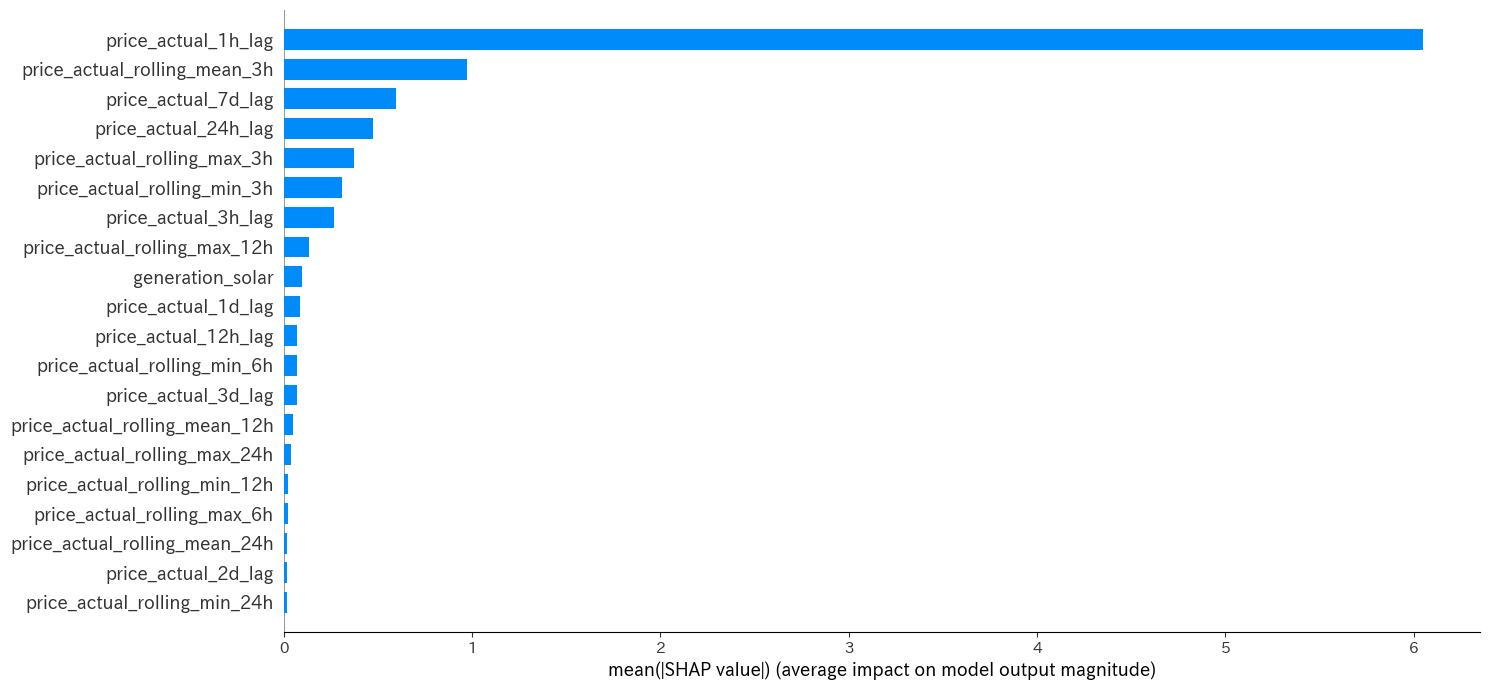

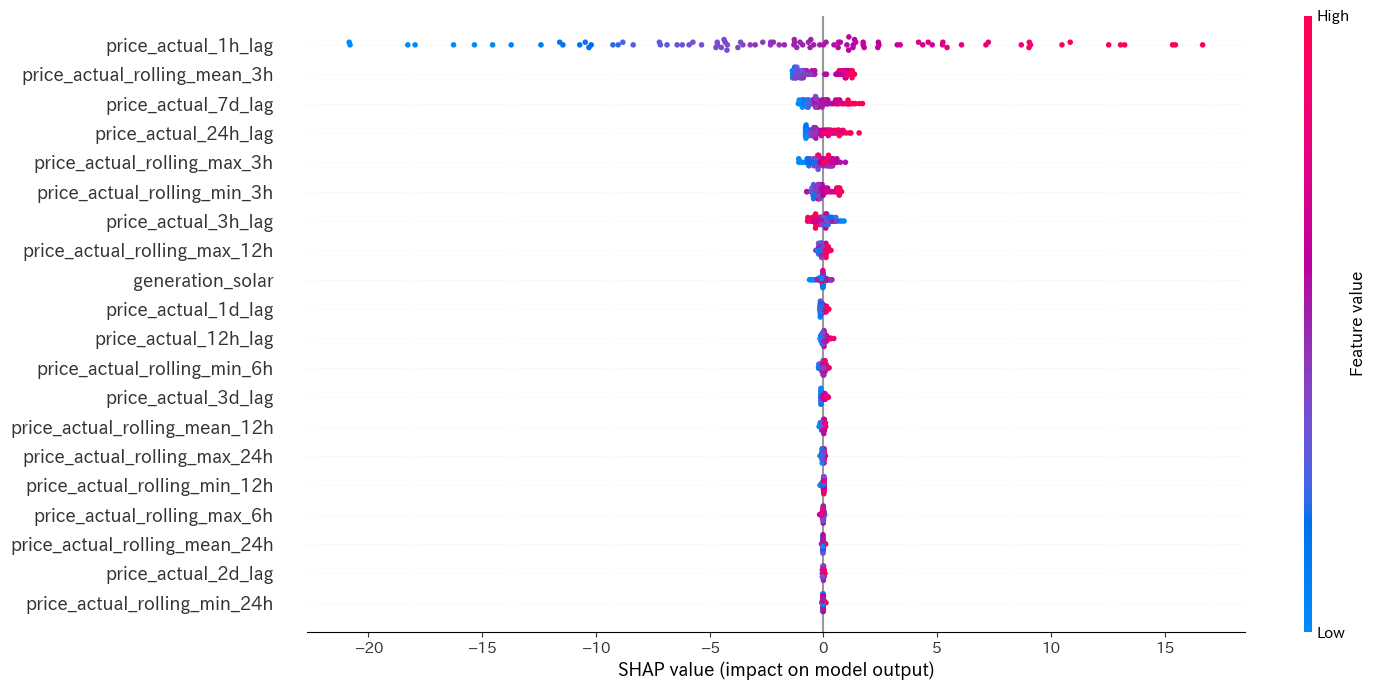

In [ ]:
# 特徴量重要度の可視化
shap.summary_plot(shap_values, shap_sample, plot_type='bar', plot_size=(15, 7))
shap.summary_plot(shap_values, shap_sample, plot_size=(15, 7))

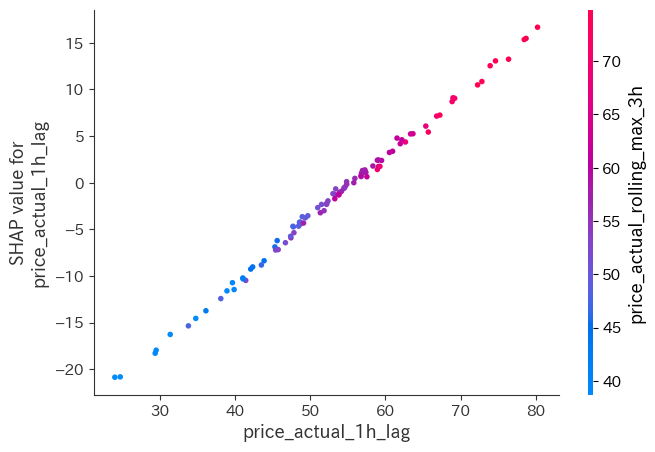

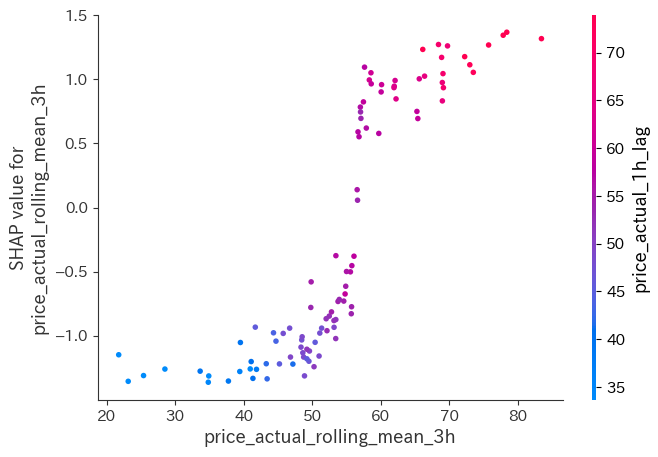

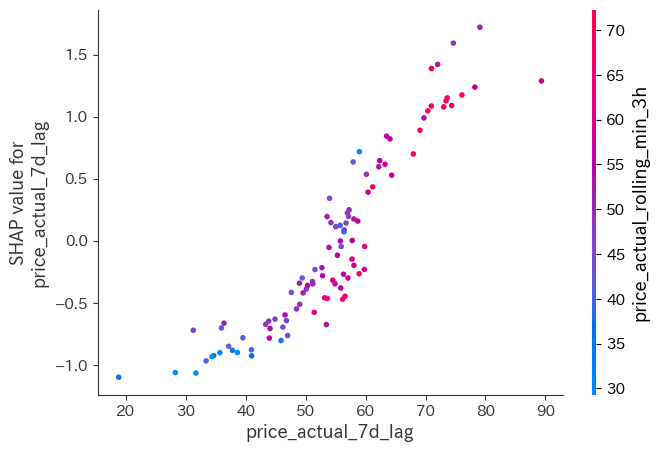

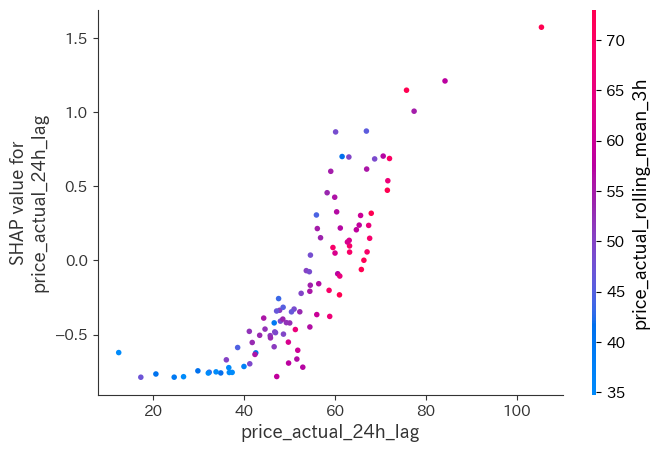

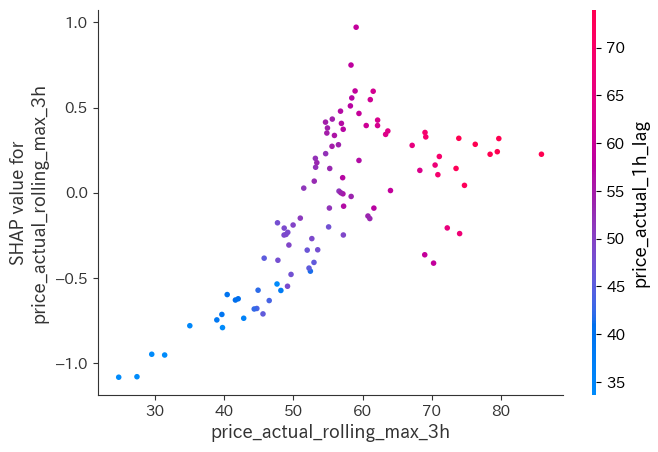

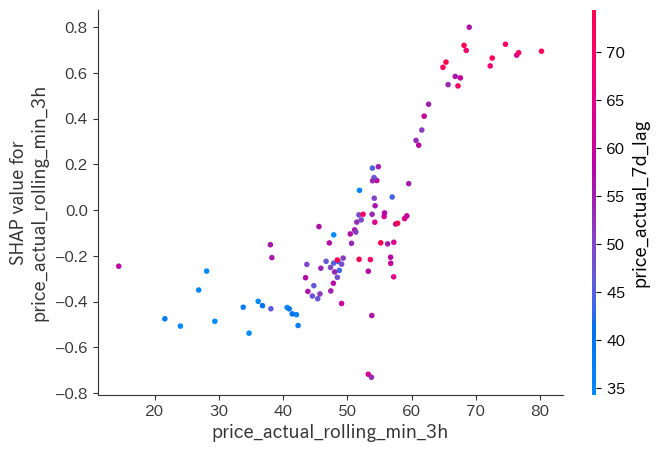

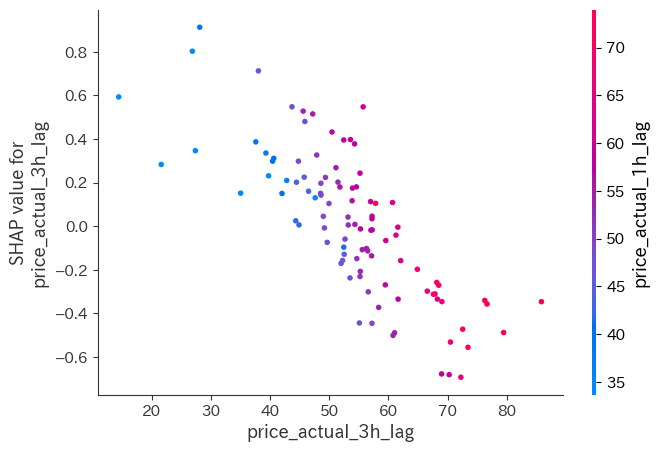

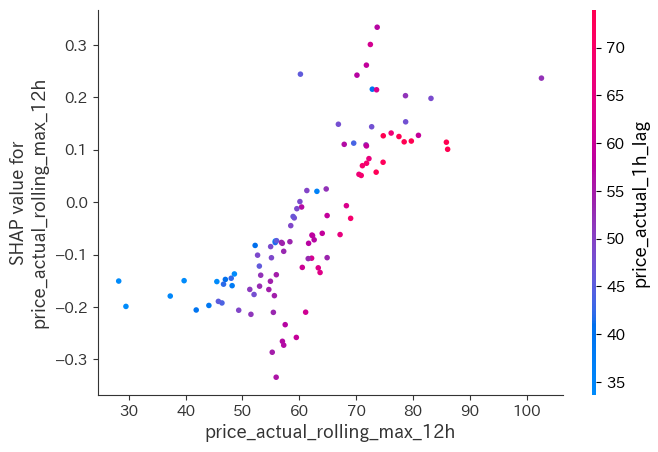

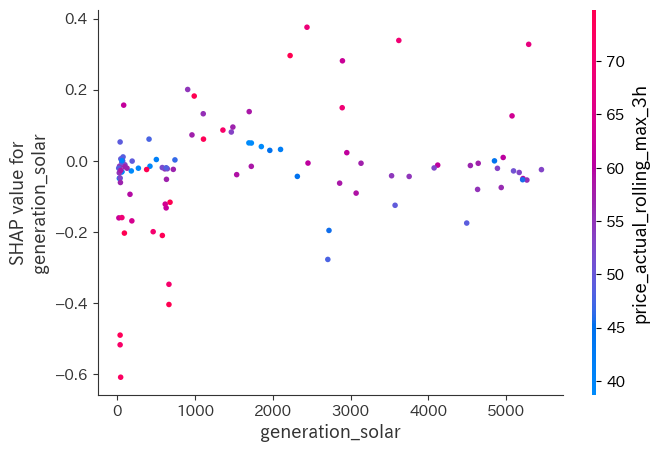

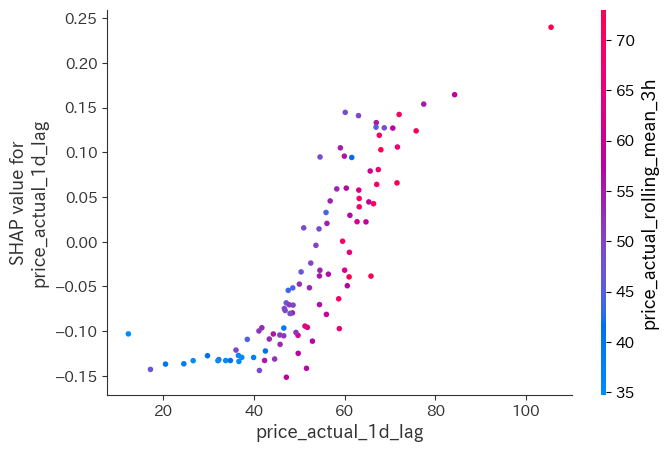

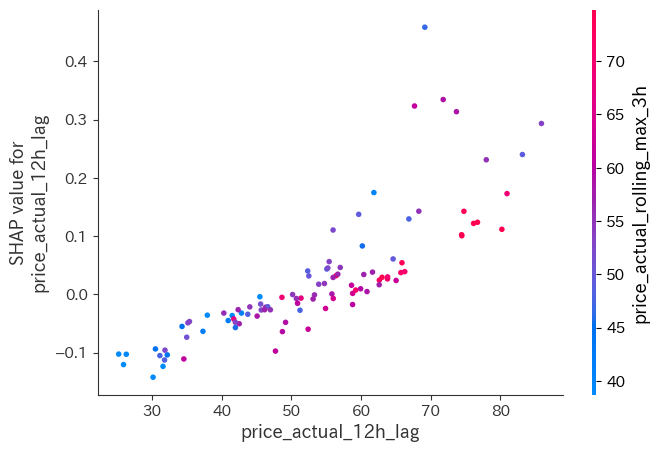

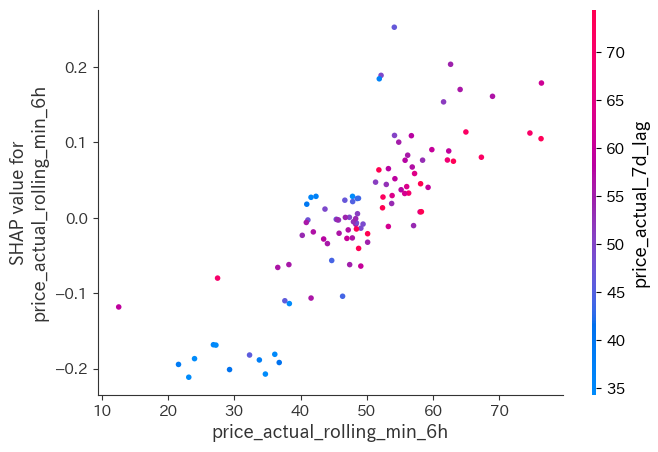

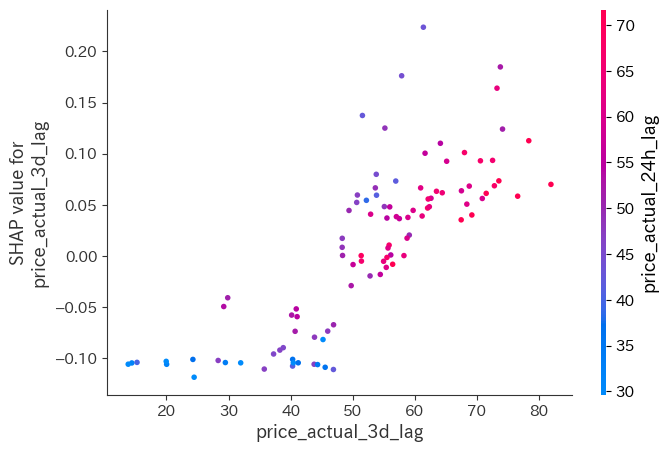

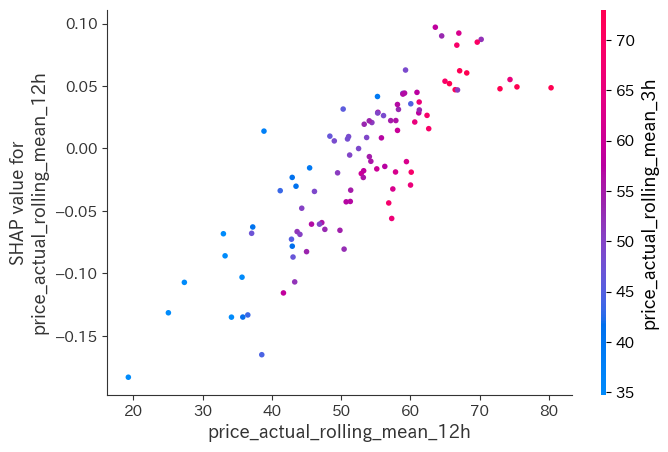

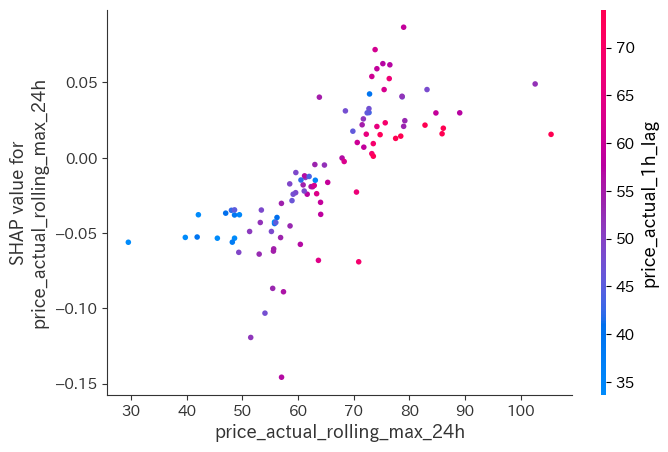

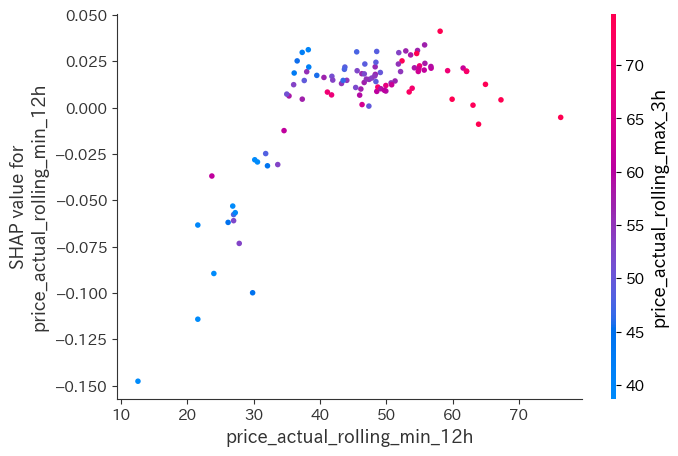

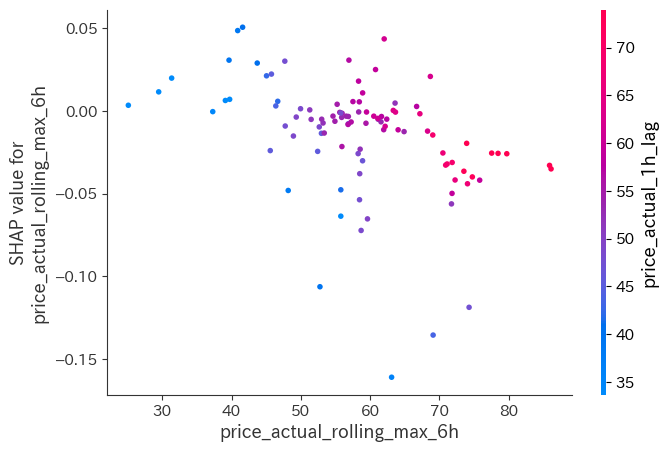

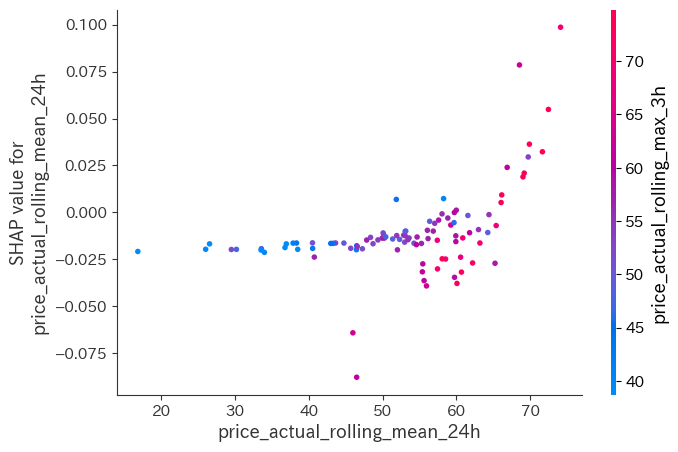

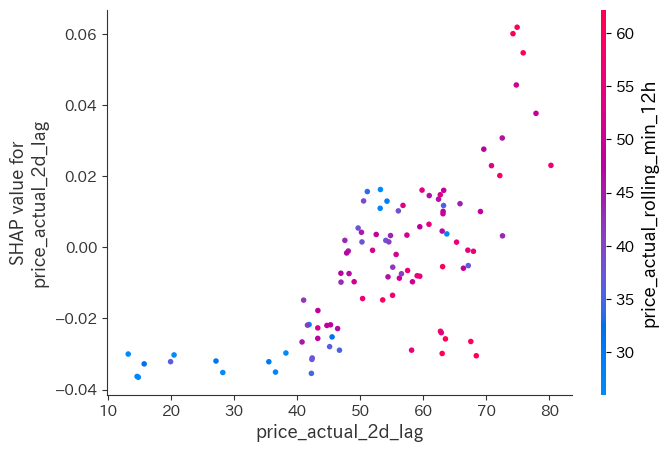

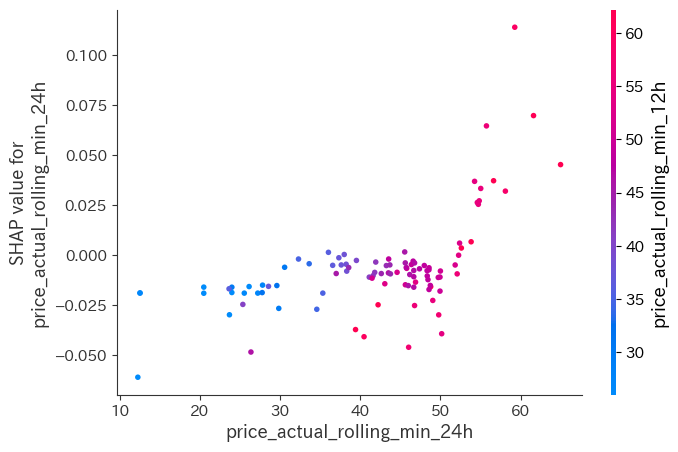

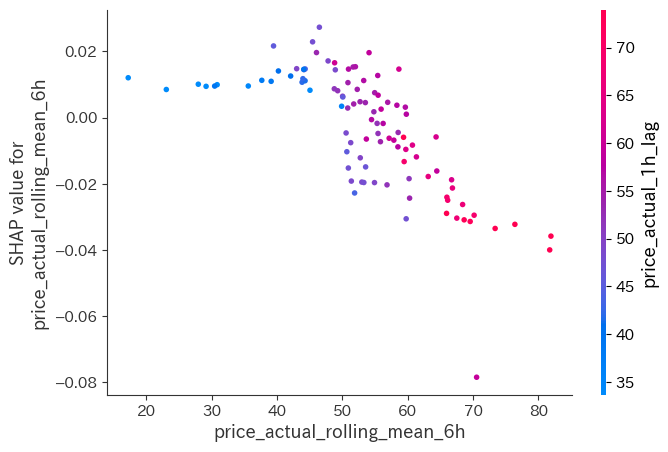

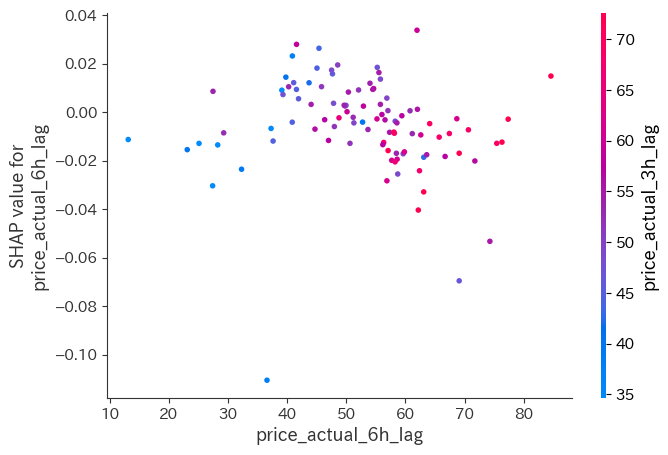

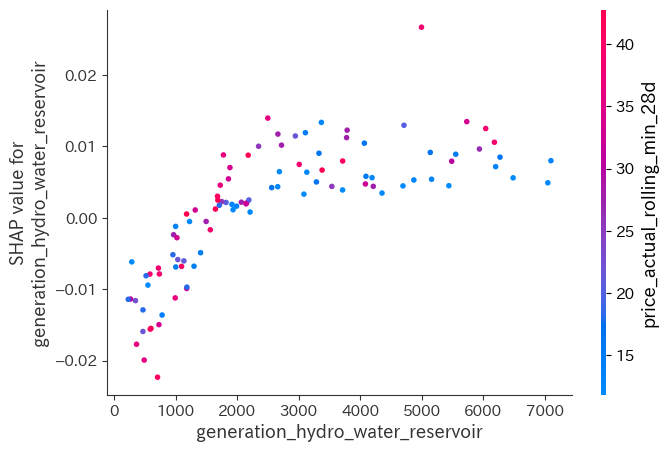

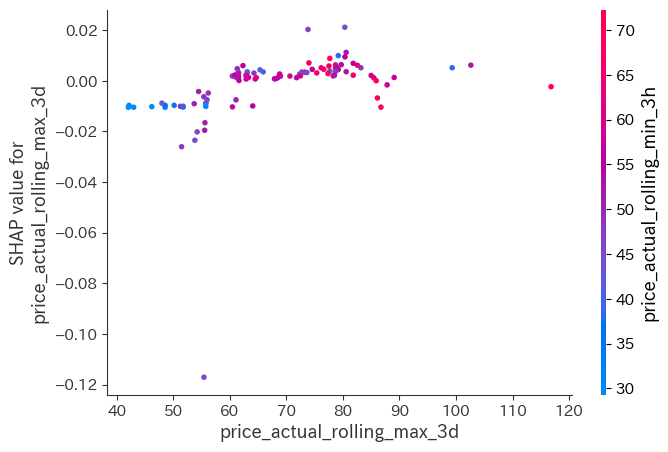

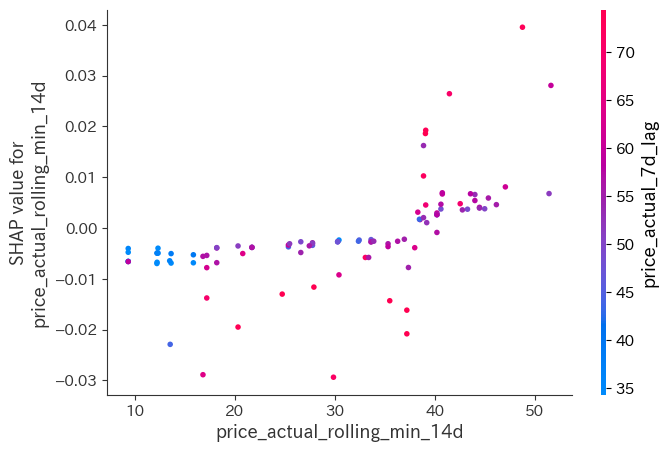

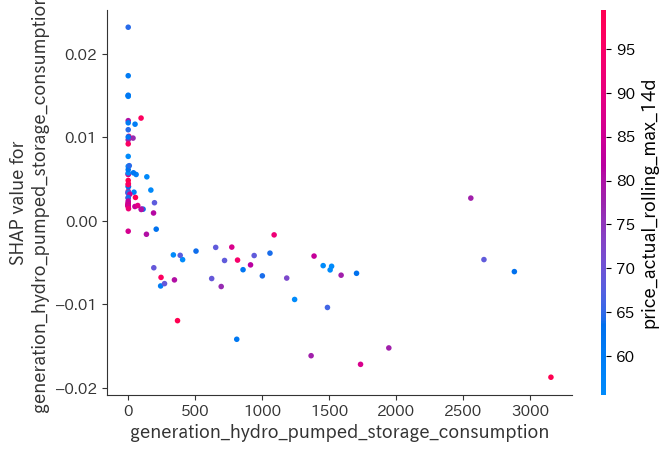

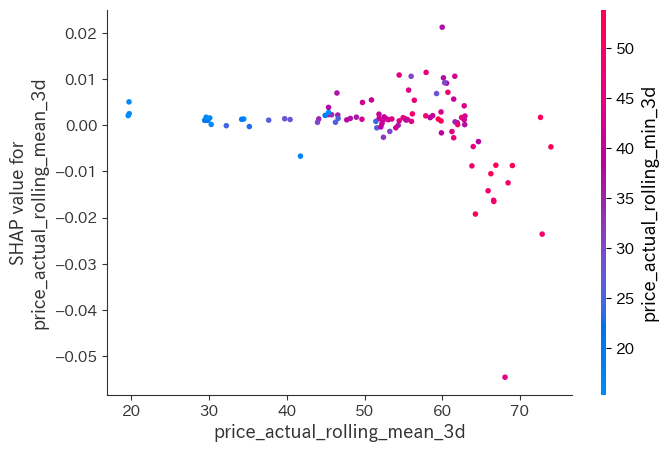

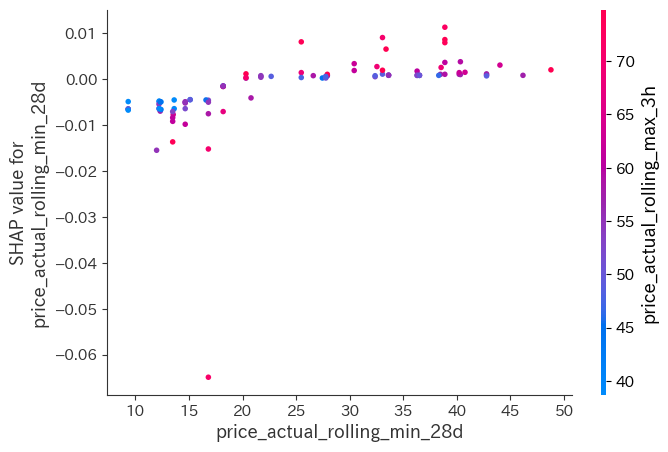

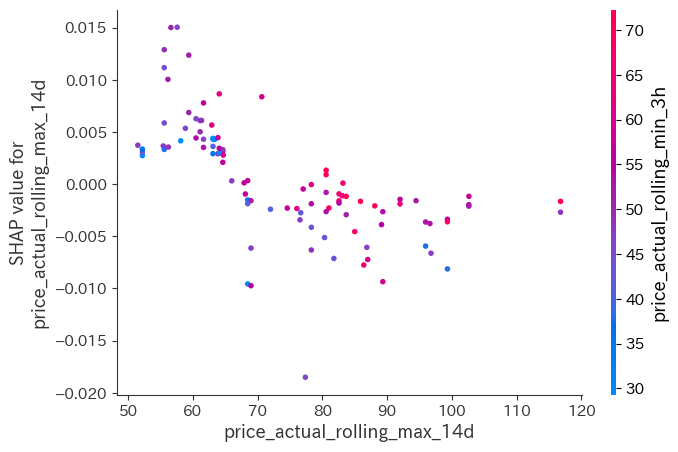

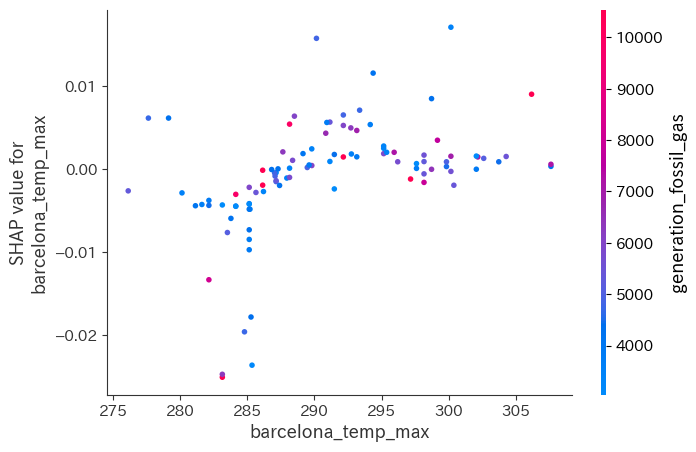

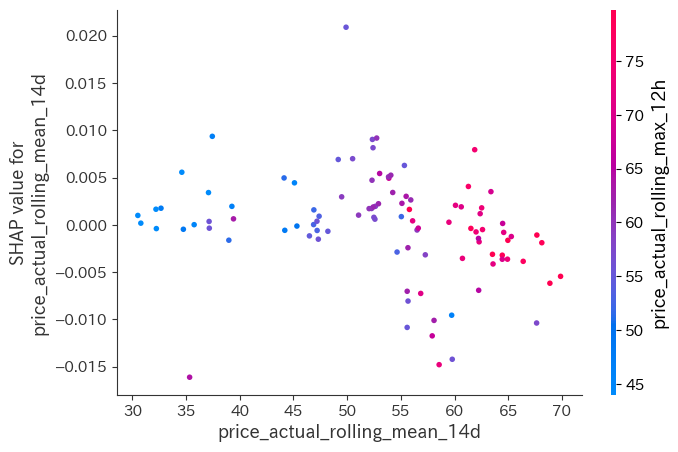

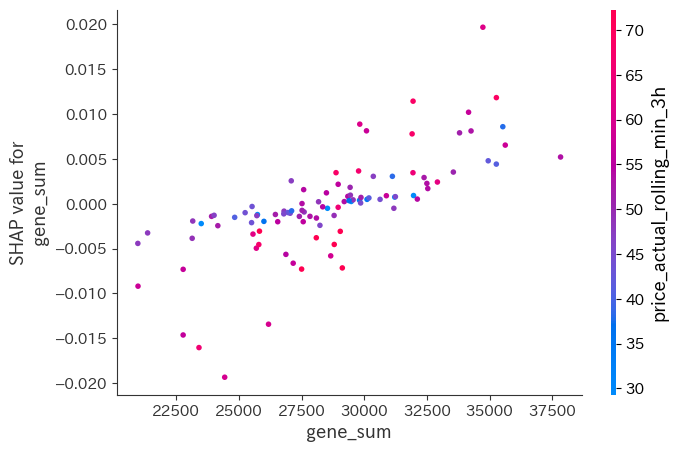

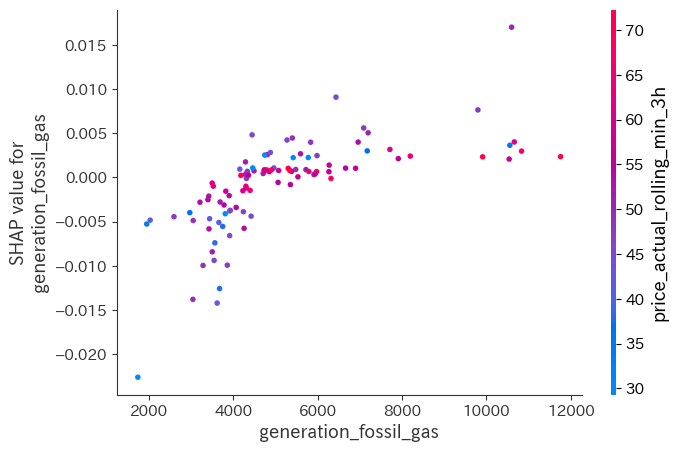

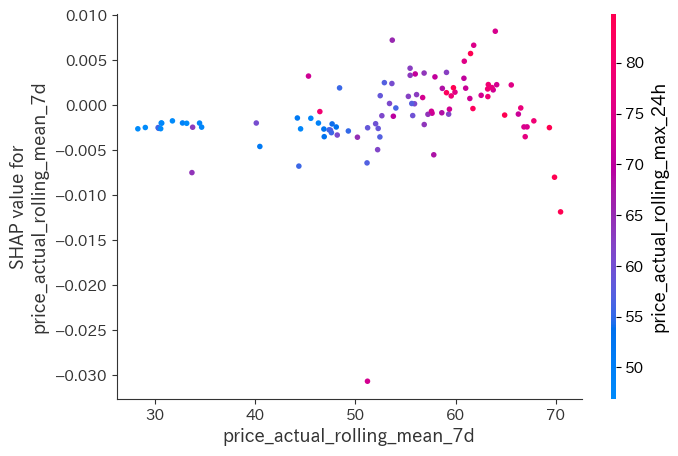

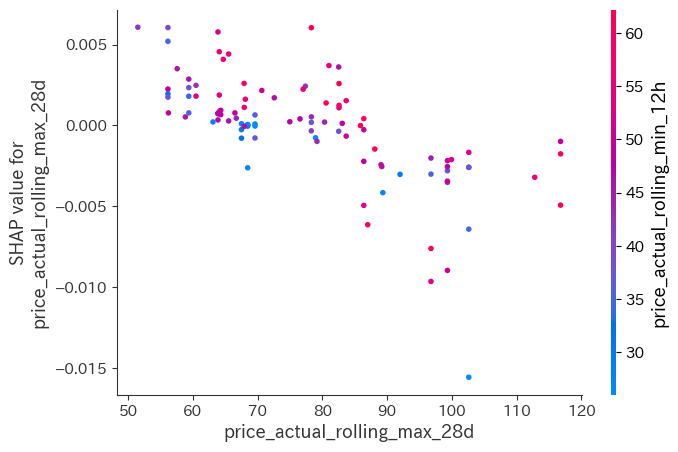

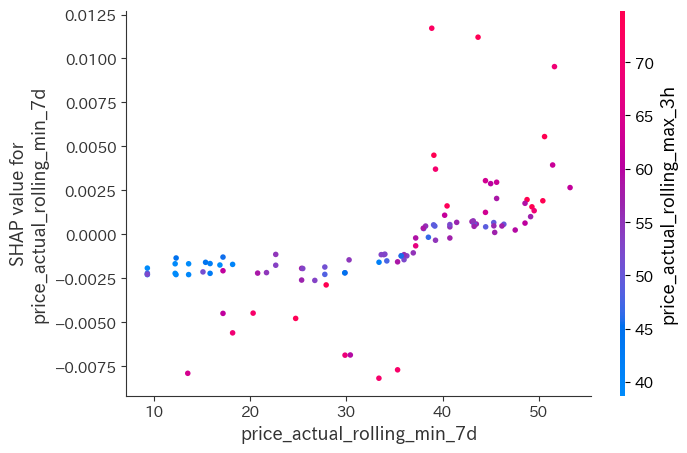

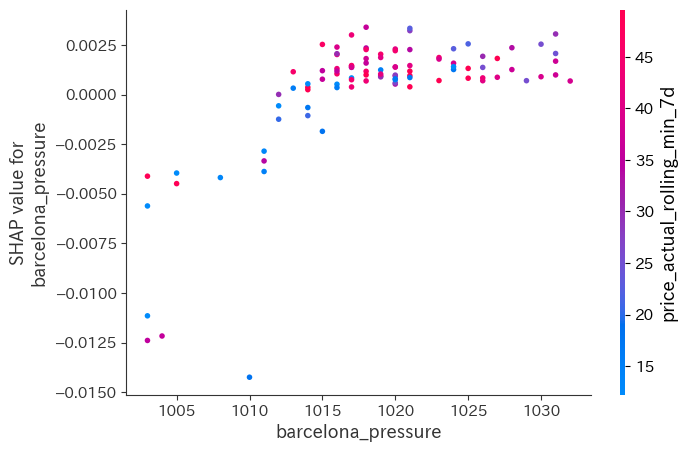

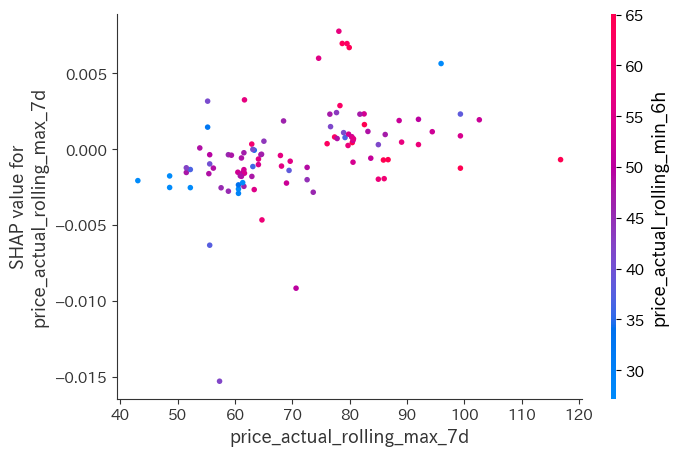

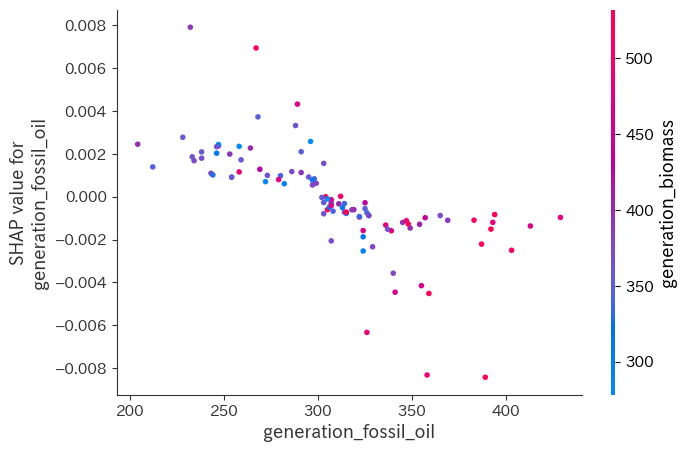

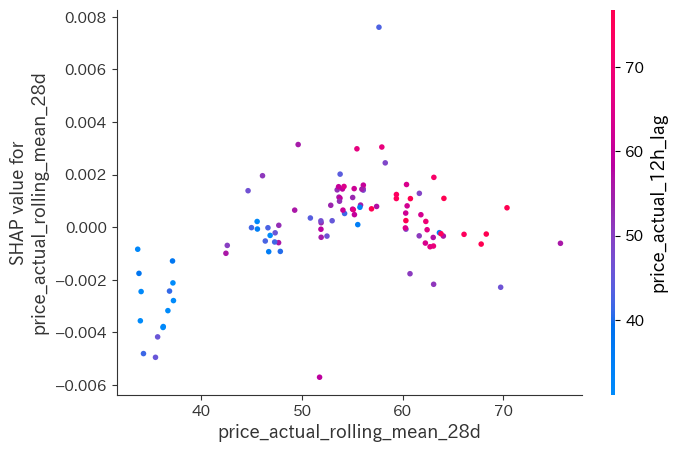

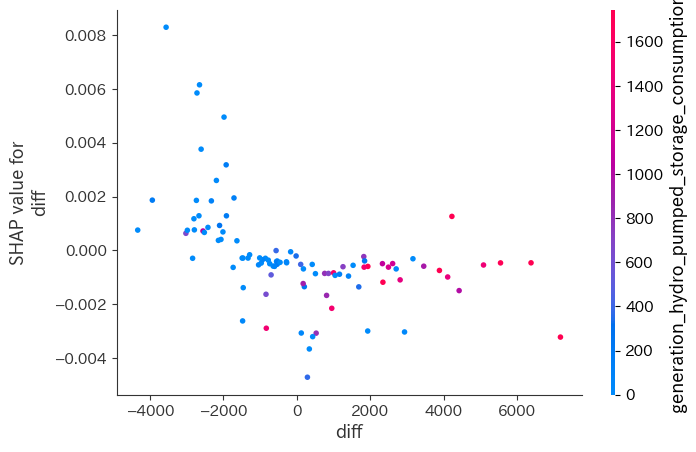

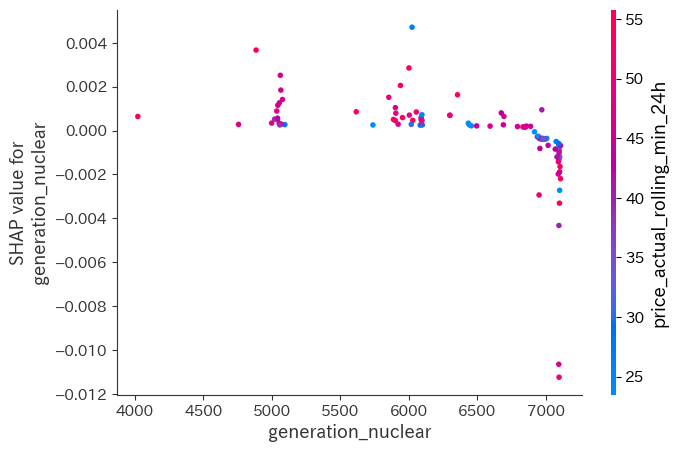

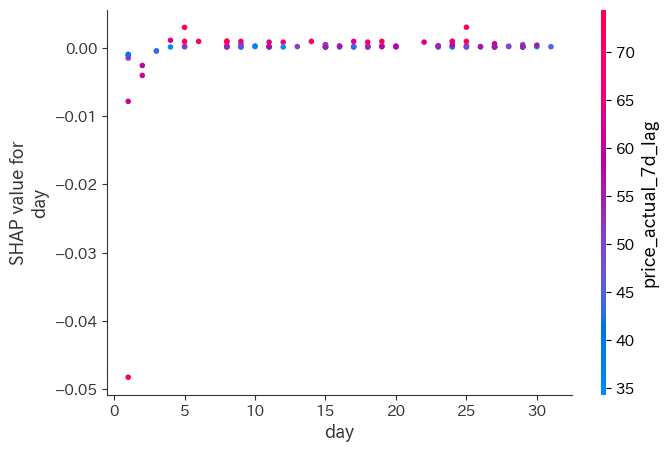

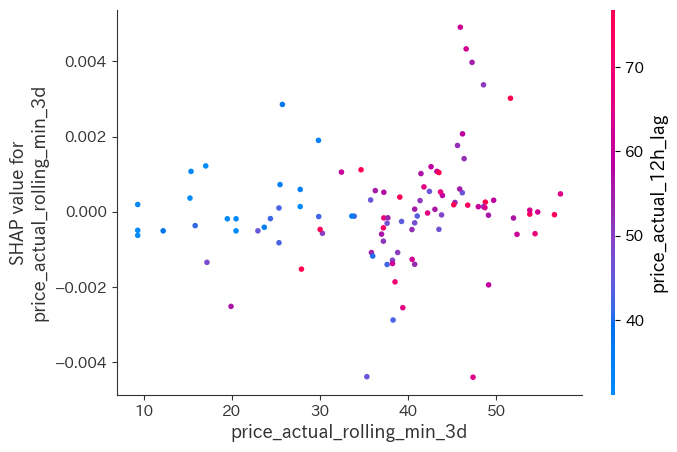

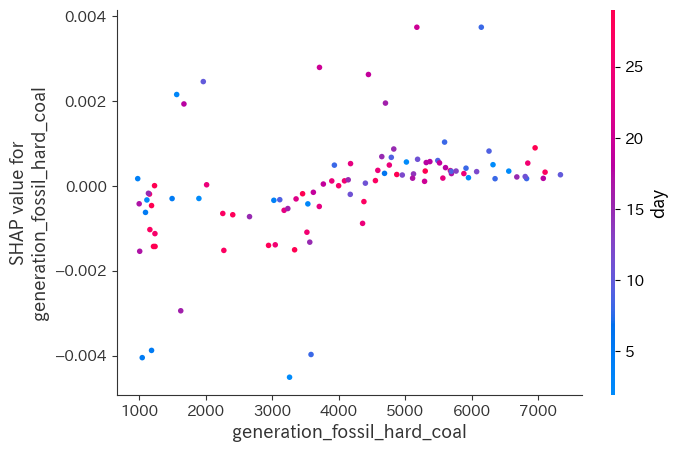

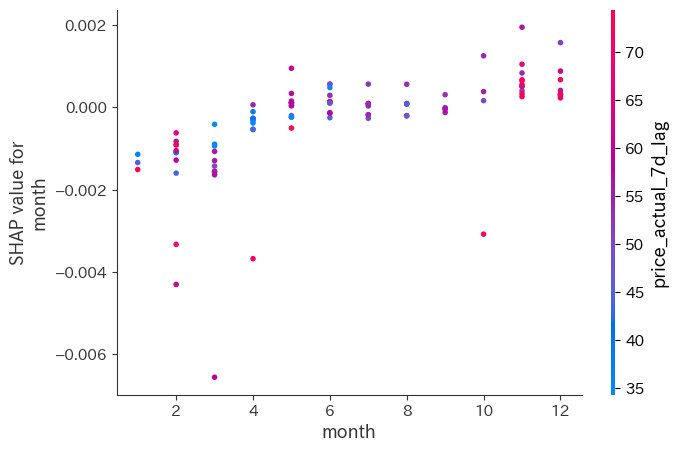

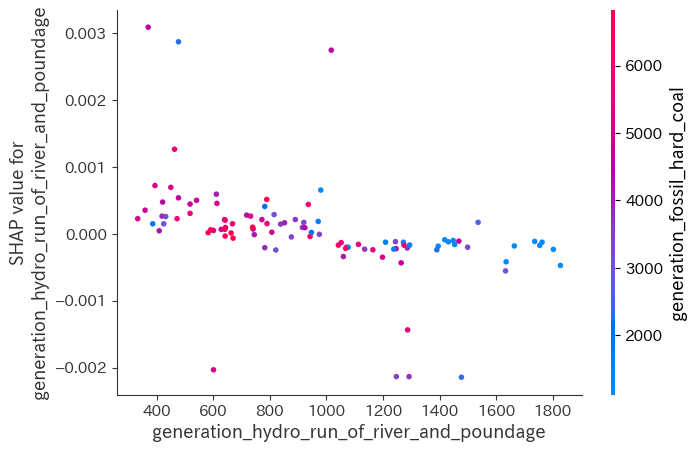

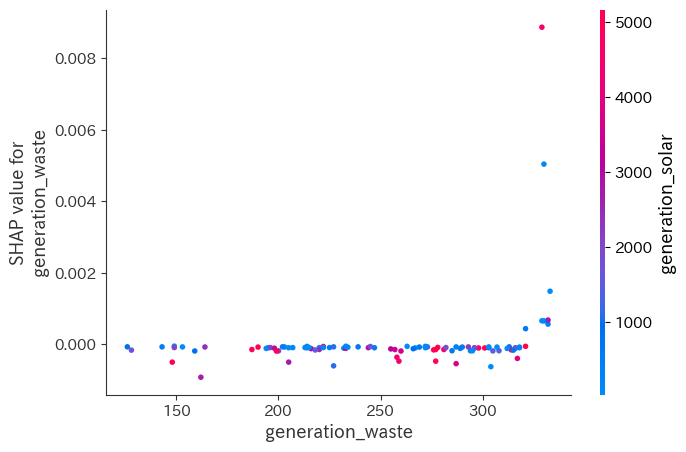

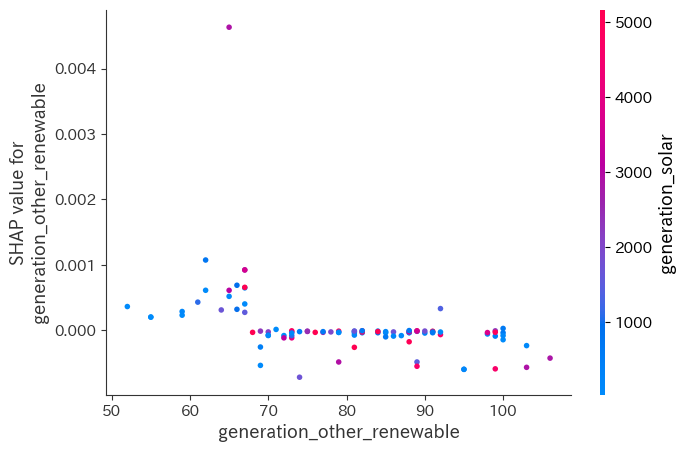

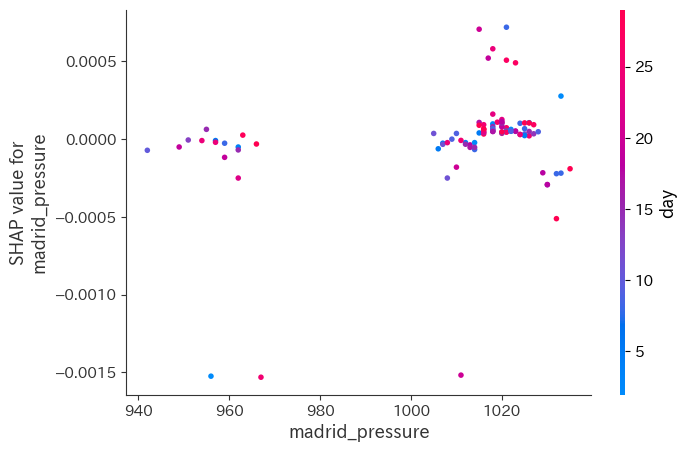

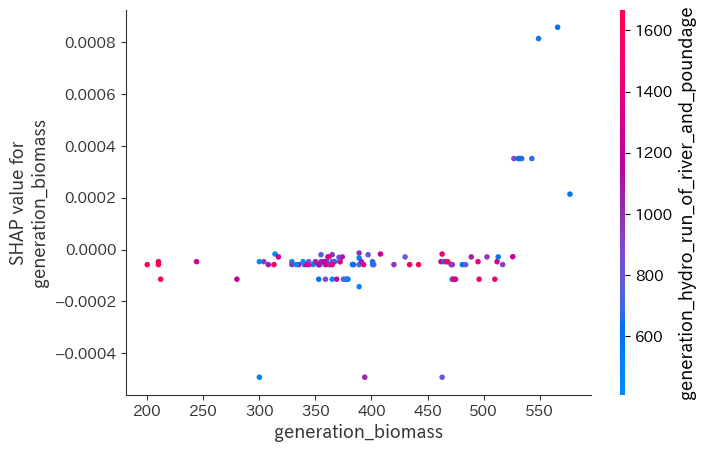

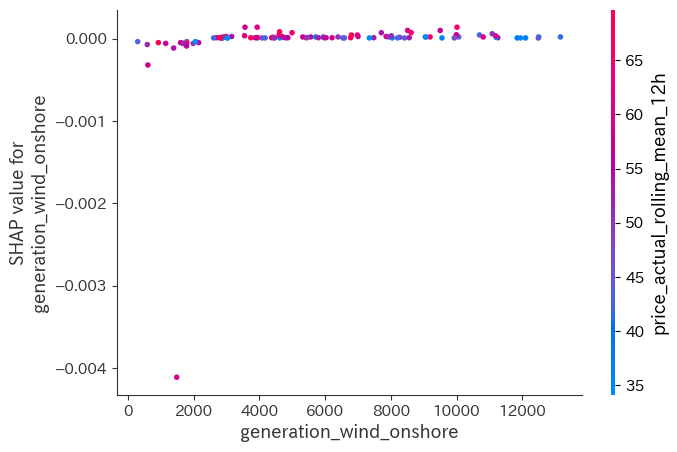

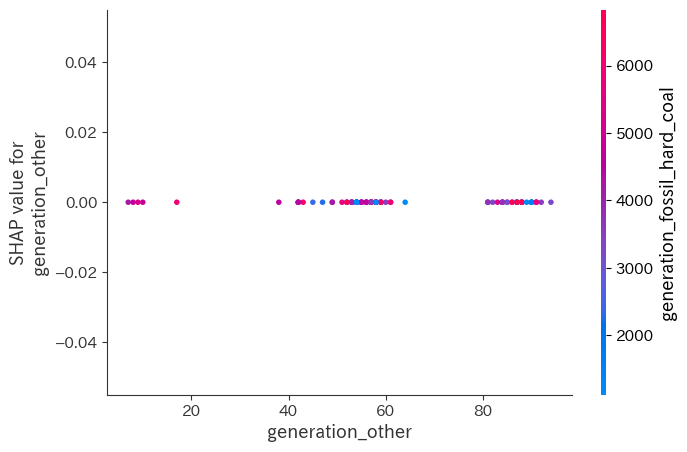

In [ ]:
# 特徴量値の変化に応じた変化を描画
for feature in shap_importance['特徴量']:
    shap.dependence_plot(feature, shap_values, shap_sample)

#### 特徴量の作用

In [ ]:
# スケーリングされた値を元のスケールに戻す関数
def _inverse_scale(values, feature_name, scaler_params_path):
    scaler_df = pd.read_csv(scaler_params_path, encoding='utf-8-sig')
    row = scaler_df[scaler_df['特徴量名'] == feature_name]

    if row.empty:
        print(f'スケーリング情報が見つかりません: {feature_name}')
        return values
    
    method = row.iloc[0]['手法']

    if method == 'std':
        mean = row.iloc[0]['mean']
        std = row.iloc[0]['std']
        return values * std + mean
    

# 学習時の特徴量のリストを取得する
def _get_model_features_for_pdp(model):
    if isinstance(model, lgb.Booster):
        return model.feature_name()
    else:
        return None


# PDPを描画する関数
def _drew_pdp(df, model_features, feature_name, pred_func, title_suffix='', num_grid_points=50, scaler_param_path=None):
    pdp_isolated = pdp.PDPIsolate(
        model=None if pred_func else model,
        df=df[model_features],
        model_features=model_features,
        feature=feature_name,
        feature_name=feature_name,
        n_classes=0,
        num_grid_points=num_grid_points,
        pred_func=pred_func
    )

    x_vals = pdp_isolated.feature_info.grids
    y_vals = pdp_isolated.results[0].pdp

    # スケーリングを元に戻す
    if scaler_param_path is not None:
        x_vals = _inverse_scale(x_vals, feature_name, scaler_param_path)
    
    plt.figure(figsize=(10, 5))
    plt.plot(x_vals, y_vals, marker='o', linestyle='-')
    plt.xlabel(feature_name)
    plt.ylabel('予測値')
    plt.title(f'特徴量の作用: {feature_name}_{title_suffix}')
    plt.grid(True)
    plt.show()


# 単一モデルに対してPDPを実施する関数
def plot_pdp(model, features, top10_feature_list, model_name='', num_grid_points=50, scaler_param_path=None):
    model_features = _get_model_features_for_pdp(model)

    def pred_func(_, X):
        if isinstance(model, lgb.Booster):
            return model.predict(pd.DataFrame(X, columns=model_features))
        
    for top_feature in top10_feature_list:
        _drew_pdp(
            features,
            model_features,
            top_feature,
            pred_func,
            title_suffix=model_name,
            num_grid_points=num_grid_points,
            scaler_param_path=scaler_param_path
        )

using provided pred_func.


100%|██████████| 150/150 [00:00<00:00, 816.58it/s]


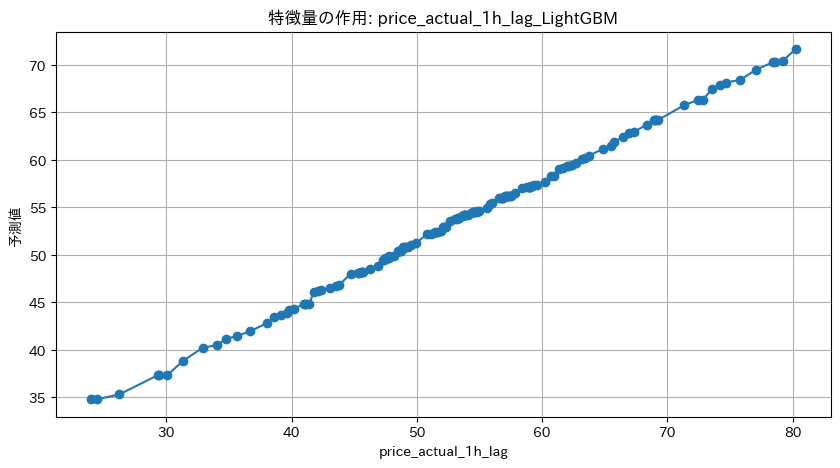

using provided pred_func.


100%|██████████| 150/150 [00:00<00:00, 499.58it/s]


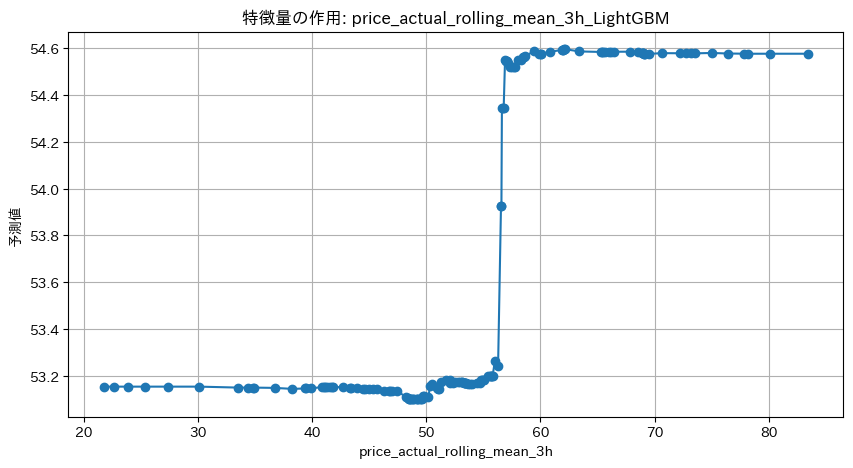

using provided pred_func.


100%|██████████| 150/150 [00:00<00:00, 684.24it/s]


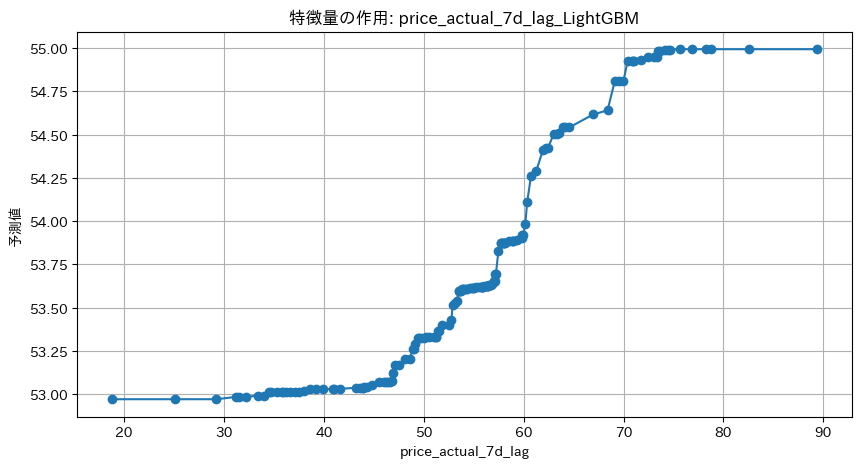

using provided pred_func.


100%|██████████| 150/150 [00:00<00:00, 744.64it/s]


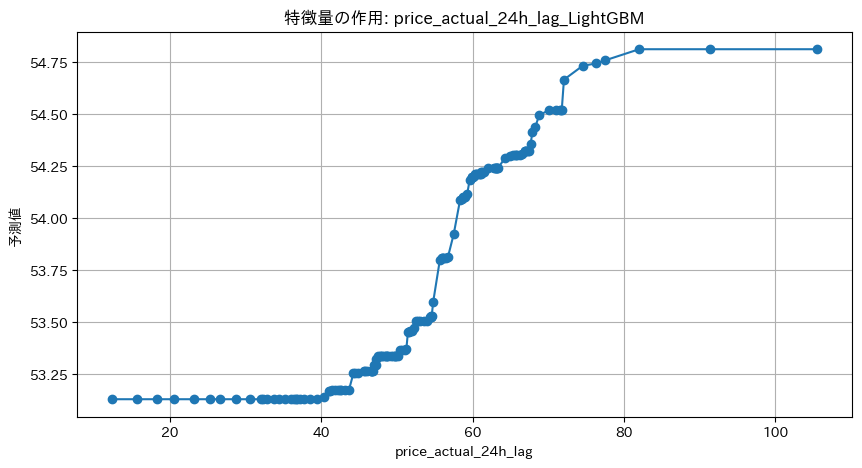

using provided pred_func.


100%|██████████| 150/150 [00:00<00:00, 729.38it/s]


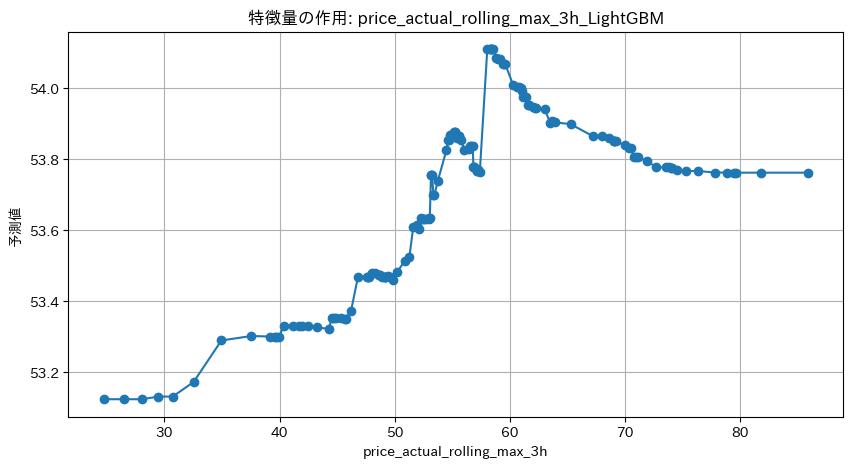

using provided pred_func.


100%|██████████| 149/149 [00:00<00:00, 778.29it/s]


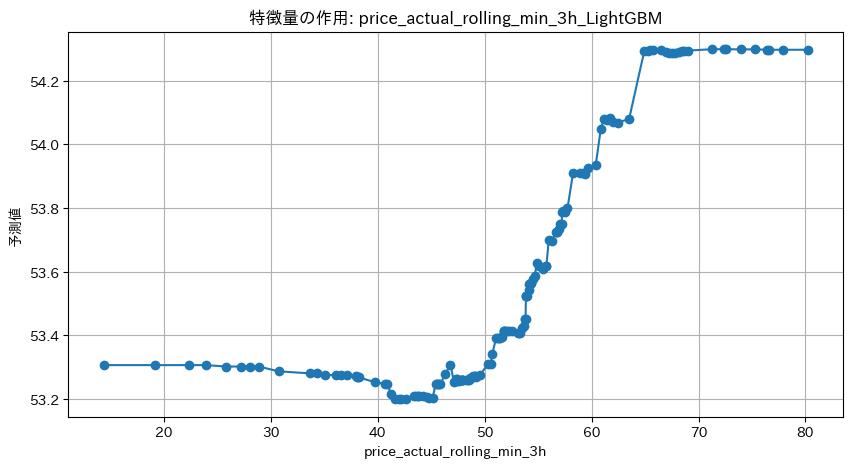

using provided pred_func.


100%|██████████| 148/148 [00:00<00:00, 777.84it/s]


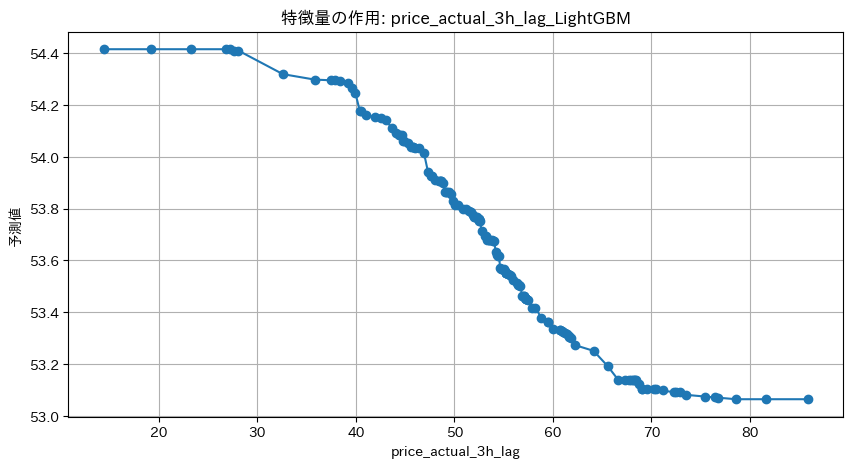

using provided pred_func.


100%|██████████| 150/150 [00:00<00:00, 767.70it/s]


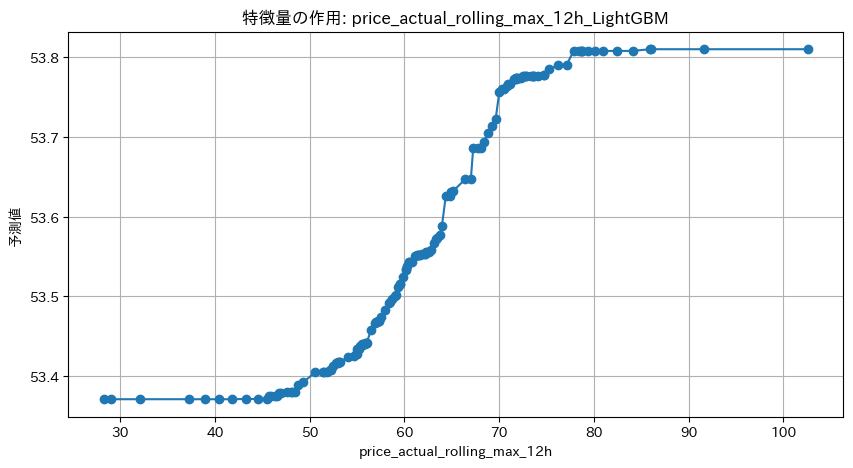

using provided pred_func.


100%|██████████| 142/142 [00:00<00:00, 765.87it/s]


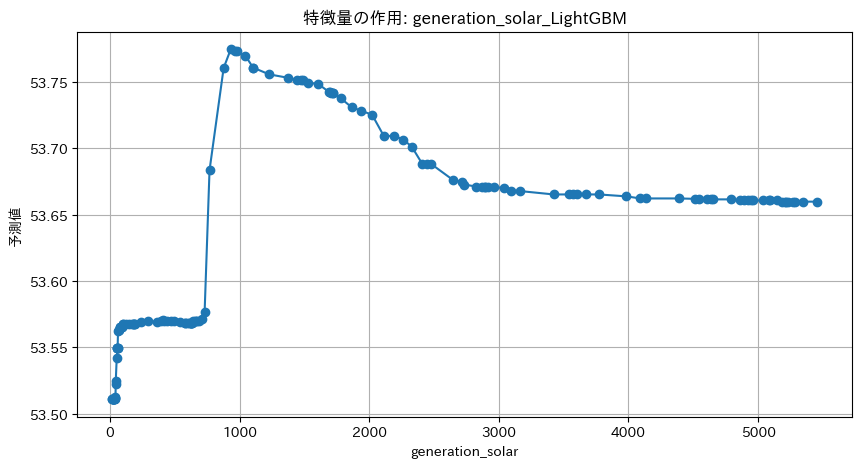

using provided pred_func.


100%|██████████| 150/150 [00:00<00:00, 758.26it/s]


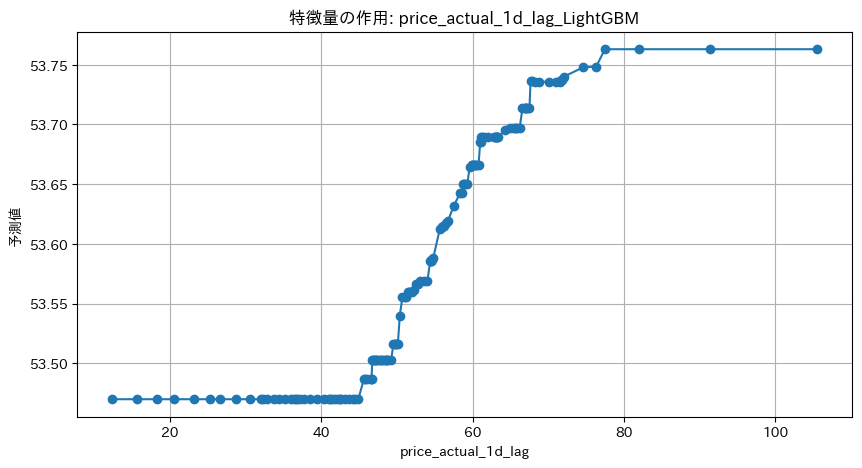

In [ ]:
top10_list = shap_importance.iloc[0:10, 0].to_list()
plot_pdp(final_model, shap_sample, top10_list, 'LightGBM', num_grid_points=150, scaler_param_path=None)